In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import scipy.stats as stats
from scipy.special import expit  # Funzione logistica
from cmdstanpy import cmdstan_path, CmdStanModel

In [2]:
# set seed to make the results fully reproducible
seed: int = sum(map(ord, "stan_poisson_regression"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%config InlineBackend.figure_format = "retina"

In [3]:
url = "https://raw.githubusercontent.com/washingtonpost/data-police-shootings/master/v2/fatal-police-shootings-data.csv"
fps_dat = pd.read_csv(url)
fps_dat.head()

,id,date,threat_type,flee_status,armed_with,city,county,state,latitude,longitude,location_precision,name,age,gender,race,race_source,was_mental_illness_related,body_camera,agency_ids
0,3,2015-01-02,point,not,gun,Shelton,Mason,WA,47.246826,-123.121592,not_available,Tim Elliot,53.0,male,A,not_available,True,False,73
1,4,2015-01-02,point,not,gun,Aloha,Washington,OR,45.487421,-122.891696,not_available,Lewis Lee Lembke,47.0,male,W,not_available,False,False,70
2,5,2015-01-03,move,not,unarmed,Wichita,Sedgwick,KS,37.694766,-97.280554,not_available,John Paul Quintero,23.0,male,H,not_available,False,False,238
3,8,2015-01-04,point,not,replica,San Francisco,San Francisco,CA,37.762910,-122.422001,not_available,Matthew Hoffman,32.0,male,W,not_available,True,False,196
4,9,2015-01-04,point,not,other,Evans,Weld,CO,40.383937,-104.692261,not_available,Michael Rodriguez,39.0,male,H,not_available,False,False,473


In [4]:
# Convert date
fps_dat["date"] = pd.to_datetime(fps_dat["date"])

# Create a new column 'year' to store the year information from the 'date' column
fps_dat["year"] = fps_dat["date"].dt.year

fps_dat.columns

Index(['id', 'date', 'threat_type', 'flee_status', 'armed_with', 'city',
       'county', 'state', 'latitude', 'longitude', 'location_precision',
       'name', 'age', 'gender', 'race', 'race_source',
       'was_mental_illness_related', 'body_camera', 'agency_ids', 'year'],
      dtype='object')

In [5]:
# Filter out rows with year equal to 2024
fps = fps_dat[fps_dat["year"] != 2024]

# Count occurrences of each year in fps
year_counts = fps["year"].value_counts()
print(year_counts)

year
2023    1161
2022    1095
2021    1050
2020    1020
2019     996
2015     995
2018     992
2017     984
2016     959
Name: count, dtype: int64


In [6]:
years = year_counts.index.to_numpy()
year = years - 2019
year

array([ 4,  3,  2,  1,  0, -4, -1, -2, -3], dtype=int32)

In [7]:
counts = year_counts.values
counts

array([1161, 1095, 1050, 1020,  996,  995,  992,  984,  959])

In [8]:
stan_data = {
    "N" : len(year),
    "y" : counts,
    "x" : year 
}
stan_data

{'N': 9,
 'y': array([1161, 1095, 1050, 1020,  996,  995,  992,  984,  959]),
 'x': array([ 4,  3,  2,  1,  0, -4, -1, -2, -3], dtype=int32)}

In [9]:
stan_file = os.path.join('stan', 'poisson_regression.stan')
with open(stan_file, 'r') as f:
    print(f.read())

data {
  int<lower=0> N;  // Numero di osservazioni
  array[N] int<lower=0> y;  // Dati di conteggio (frequenze)
  vector[N] x;  // Variabile predittore (anni, già standardizzata)
}

parameters {
  real alpha;  // Intercetta
  real beta;  // Pendenza
}

model {
  // Priors debolmente informativi
  alpha ~ normal(0, 10);
  beta ~ normal(0, 10);

  // Modello di regressione di Poisson
  y ~ poisson_log(alpha + beta * x);
}

generated quantities {
  array[N] int<lower=0> y_pred = poisson_log_rng(alpha + beta * x);
}



In [10]:
model = CmdStanModel(stan_file=stan_file)
print(model)

CmdStanModel: name=poisson_regression
	 stan_file=/Users/corradocaudek/_repositories/temp/chapter_5/stan/poisson_regression.stan
	 exe_file=/Users/corradocaudek/_repositories/temp/chapter_5/stan/poisson_regression
	 compiler_options=stanc_options={}, cpp_options={}


In [11]:
fit = model.sample(data=stan_data)

09:49:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:49:32 - cmdstanpy - INFO - CmdStan done processing.


In [12]:
az.summary(fit, var_names=(["alpha", "beta"]), hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,6.934,0.011,6.912,6.954,0.0,0.0,2589.0,2120.0,1.0
beta,0.020,0.004,0.012,0.028,0.0,0.0,3875.0,2741.0,1.0


In [13]:
np.exp(6.934)

1026.5921464104808

In [14]:
np.exp([0.020, 0.012, 0.028])

array([1.02020134, 1.01207229, 1.02839568])

In [15]:
# Parametri del modello
alpha_mean = 6.934
beta_mean = 0.020

# Calcolo del tasso di frequenza base per l'anno centrato (exp(alpha))
tasso_base = np.exp(alpha_mean)

# Calcolo del fattore di moltiplicazione per l'aumento (exp(beta))
fattore_moltiplicazione = np.exp(beta_mean)

# Aumento atteso in frequenza per un anno
aumento_atteso = tasso_base * (fattore_moltiplicazione - 1)
aumento_atteso

20.738537018435174

In [16]:
y_observed = stan_data["y"]

idata = az.from_cmdstanpy(
    posterior=fit,
    posterior_predictive='y_pred',
    observed_data={'y': y_observed}
)

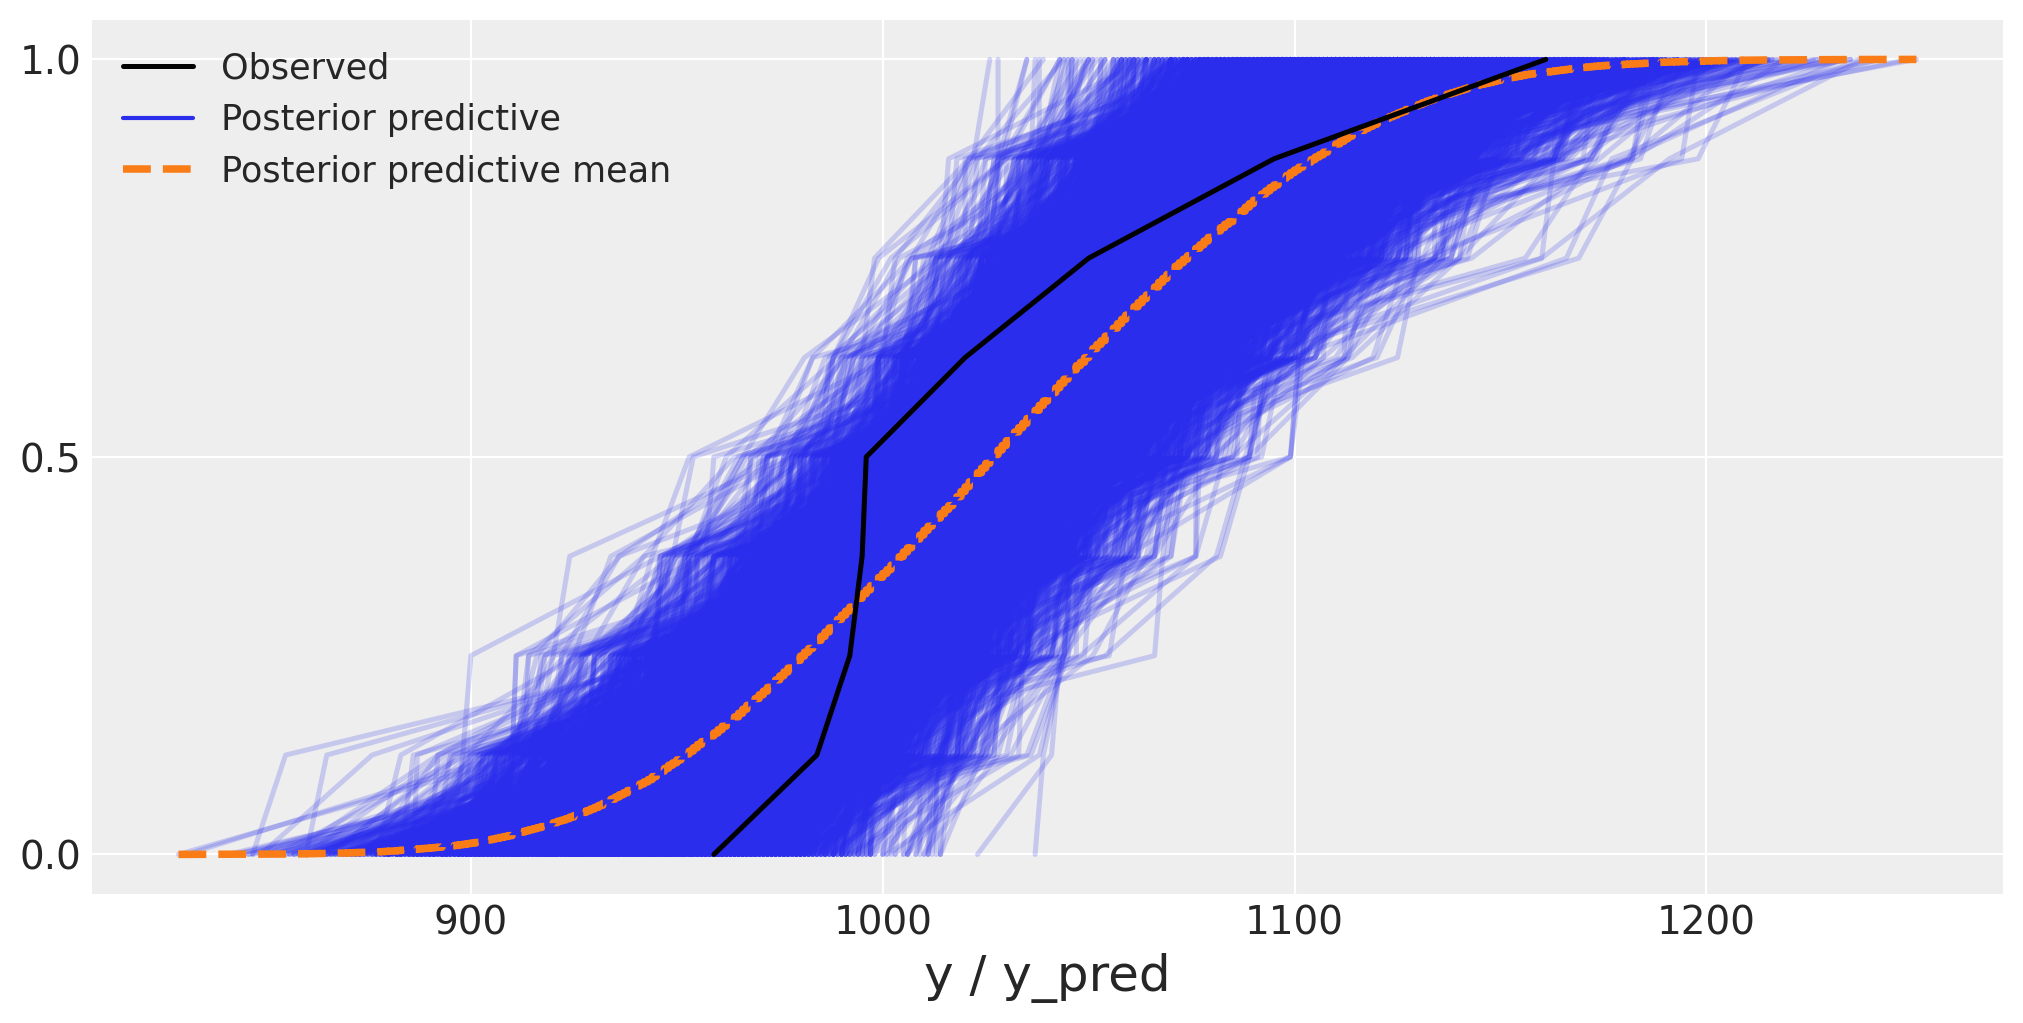

In [17]:
_ = az.plot_ppc(idata, data_pairs={'y': 'y_pred'}, kind='cumulative', figsize=(10, 5))

In [18]:
%load_ext watermark
%watermark -n -u -v -iv -w -m -p cmdstanpy

Last updated: Sun Jun 16 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

cmdstanpy: 1.2.3

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

seaborn   : 0.13.2
numpy     : 1.26.4
pandas    : 2.2.2
matplotlib: 3.8.4
scipy     : 1.13.1
arviz     : 0.18.0

Watermark: 2.4.3

